In [20]:
from keras.initializers import VarianceScaling
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
from utils.dec import DEC
from sklearn.preprocessing import MinMaxScaler

In [21]:
# load dataset
from keras.datasets import mnist
(x, y), (x_test, y_test) = mnist.load_data(path='mnist.npz')
n_clusters = len(np.unique(y))
x = np.reshape(x, [x.shape[0], x.shape[1] * x.shape[2]])
x_test = np.reshape(x_test, [x_test.shape[0], x_test.shape[1] * x_test.shape[2]])
x_test = x_test/255
x = x/255

In [22]:
x.shape

(60000, 784)

In [23]:
y

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [13]:
dims = [x.shape[-1], 500, 500, 2000, 10]

loss = 'mse'
optimizer = SGD(1., 0.9)
init = VarianceScaling(scale=1./3., mode='fan_in', distribution='uniform')
n_clusters=10

# DEC model
dec = DEC(dims=dims, n_clusters=n_clusters, initializer=init)
dec.compile(optimizer=optimizer, loss=loss)
dec.model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 clustering (ClusteringLaye  (None, 10)                100       
 r)                                                              
                                                            

C:\Users\vioritiva\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [14]:
init = 'glorot_uniform'
pretrain_optimizer = 'adam'
update_interval = 140
pretrain_epochs = 1000
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                            distribution='uniform')  # [-limit, limit], limit=sqrt(1./fan_in)
pretrain_optimizer = SGD(learning_rate=1., momentum=0.9)
dec.pretrain(x=x, optimizer=pretrain_optimizer,
                    epochs=pretrain_epochs,save_dir=None)
dec.compile(optimizer=SGD(0.01, 0.9), loss='kld')
dec.fit(x,
                update_interval=update_interval,
                save_dir=None)

Pretraining autoencoder model...
Epoch 1/500

235/235 [==============================] - 8s 29ms/step - loss: 0.0656
Epoch 2/500
235/235 [==============================] - 7s 29ms/step - loss: 0.0469
Epoch 3/500
235/235 [==============================] - 7s 28ms/step - loss: 0.0344
Epoch 4/500
235/235 [==============================] - 7s 28ms/step - loss: 0.0282
Epoch 5/500
235/235 [==============================] - 7s 29ms/step - loss: 0.0253
Epoch 6/500
235/235 [==============================] - 7s 28ms/step - loss: 0.0235
Epoch 7/500
235/235 [==============================] - 7s 28ms/step - loss: 0.0223
Epoch 8/500
235/235 [==============================] - 7s 28ms/step - loss: 0.0213
Epoch 9/500
235/235 [==============================] - 7s 29ms/step - loss: 0.0205
Epoch 10/500
235/235 [==============================] - 7s 28ms/step - loss: 0.0198
Epoch 11/500
235/235 [==============================] - 7s 30ms/step - loss: 0.0192
Epoch 12/500
235/235 [=============================

array([2, 6, 5, ..., 2, 1, 9], dtype=int64)

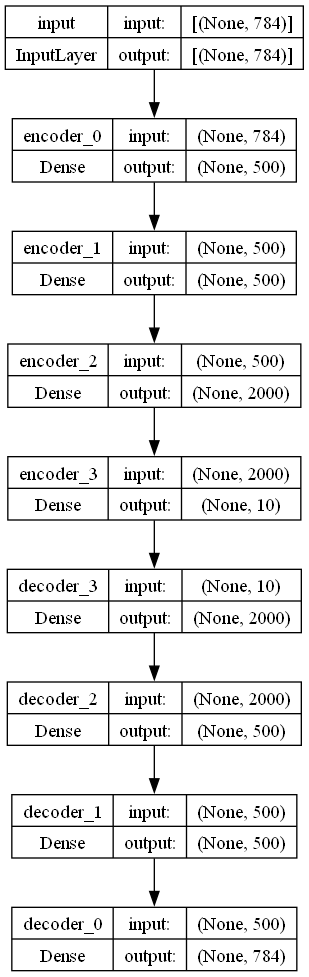

In [15]:
from keras.utils import plot_model
plot_model(dec._autoencoder, to_file='./results/autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='./results/autoencoder.png')

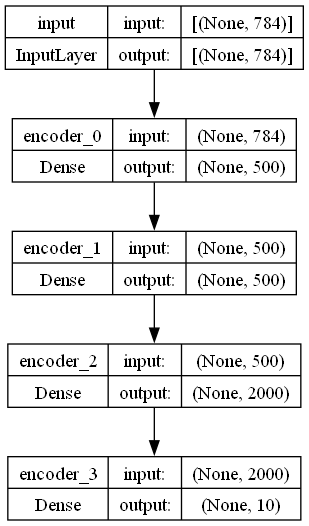

In [16]:
from keras.utils import plot_model
plot_model(dec._encoder, to_file='./results/encoder_mnist.png', show_shapes=True)
from IPython.display import Image
Image(filename='./results/encoder_mnist.png')

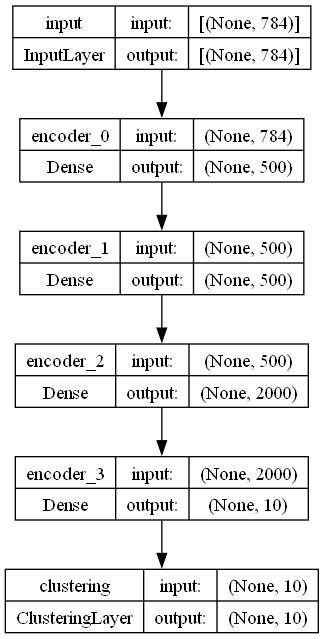

In [17]:
from keras.utils import plot_model
plot_model(dec._model, to_file='./results/dec_mnist.png', show_shapes=True)
from IPython.display import Image
Image(filename='./results/dec_mnist.png')

In [18]:
y_pred = dec.predict(x)

In [19]:
relation = dict((x, 0) for x in range(n_clusters))
#Creating a Mapping Between Predicted Labels and Clusters Based on Majority Labels within Each Clusterrelation = dict((x, 0) for x in range(n_clusters))
for i in range(n_clusters):
    u, indeces = np.unique(y_pred[y == i], return_inverse=True)
    i_pred = u[np.argmax(np.bincount(indeces))]
    relation[i_pred] = i
    
relation

{0: 9, 1: 6, 2: 5, 3: 3, 4: 1, 5: 4, 6: 0, 7: 7, 8: 2, 9: 8}

In [20]:
y_pred_corr = np.array(list(map(lambda x: relation[x], y_pred)))

In [21]:
print (y[:30])
print (y_pred_corr[:30])


[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 2 2 4 3 2 7]


In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_pred_corr)

0.9403833333333333

In [23]:
from sklearn.metrics import normalized_mutual_info_score

normalized_mutual_info_score(y, y_pred_corr)

0.8624058169734278

In [24]:
from sklearn.metrics import silhouette_score
# Calculate the silhouette score
silhouette_avg = silhouette_score(x, y_pred)

print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.04956418164813176


X_test

In [25]:
y_pred_test = dec.predict(x_test)

In [26]:
#Creating a Mapping Between Predicted Labels and Clusters Based on Majority Labels within Each Cluster
relation = dict((x_test, 0) for x_test in range(n_clusters))
for i in range(n_clusters):
    u, indeces = np.unique(y_pred_test[y_test == i], return_inverse=True)
    i_pred = u[np.argmax(np.bincount(indeces))]
    relation[i_pred] = i
    
relation

{0: 9, 1: 6, 2: 5, 3: 3, 4: 1, 5: 4, 6: 0, 7: 7, 8: 2, 9: 8}

In [27]:
y_pred_corr_test = np.array(list(map(lambda x_test1: relation[x_test], y_pred_test)))

In [28]:
print (y_test[:30])
print (y_pred_corr_test[:30])


[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]


In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_corr_test)

0.9388

In [30]:
from sklearn.metrics import normalized_mutual_info_score

normalized_mutual_info_score(y_test, y_pred_corr_test)

0.862132040315034

In [31]:
from sklearn.metrics import silhouette_score
# Calculate the silhouette score
silhouette_avg = silhouette_score(x_test, y_pred_test)

print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.05551539761703633


Visualization

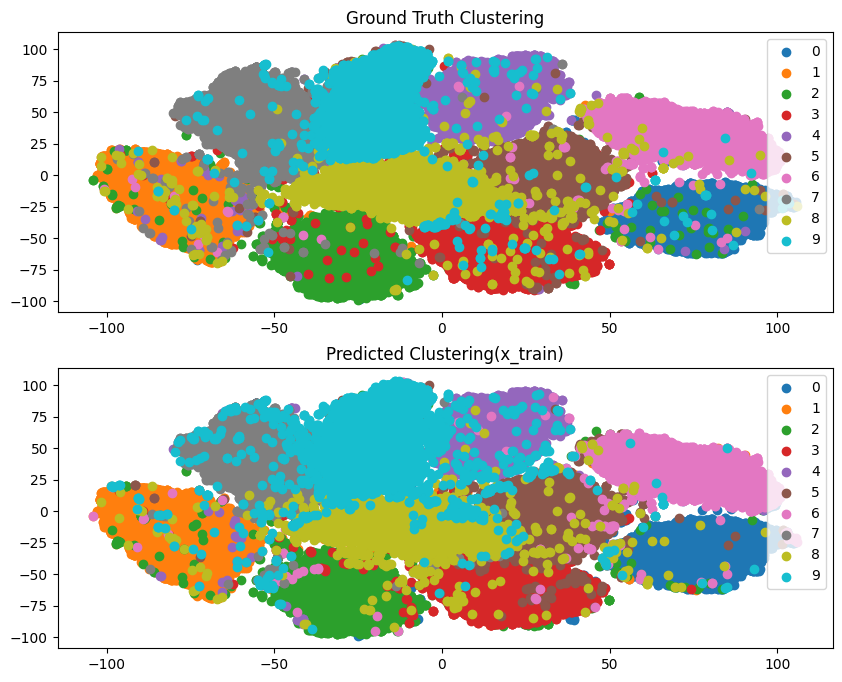

In [32]:
#x_train
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(x)


plt.figure(figsize=(10, 8))

# Plot ground truth labels
plt.subplot(2, 1, 1)
for i in range(10):
    plt.scatter(X_tsne[y == i, 0], X_tsne[y == i, 1], label=str(i))
plt.title('Ground Truth Clustering')
plt.legend()

# Plot predicted labels
plt.subplot(2, 1, 2)
for i in range(10):
    plt.scatter(X_tsne[y_pred_corr == i, 0], X_tsne[y_pred_corr == i, 1], label=str(i))
plt.title('Predicted Clustering(x_train)')
plt.legend()

plt.show()


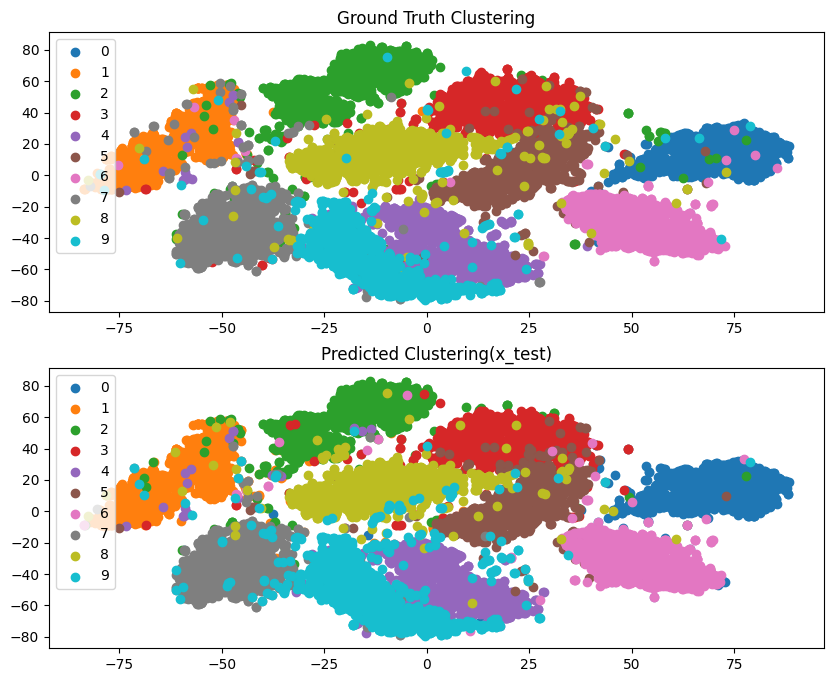

In [33]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(x_test1)

plt.figure(figsize=(10, 8))

# Plot ground truth labels
plt.subplot(2, 1, 1)
for i in range(10):
    plt.scatter(X_tsne[y_test == i, 0], X_tsne[y_test == i, 1], label=str(i))
plt.title('Ground Truth Clustering')
plt.legend()

# Plot predicted labels
plt.subplot(2, 1, 2)
for i in range(10):
    plt.scatter(X_tsne[y_pred_corr_test == i, 0], X_tsne[y_pred_corr_test == i, 1], label=str(i))
plt.title('Predicted Clustering(x_test)')
plt.legend()

plt.show()


In [40]:
X

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

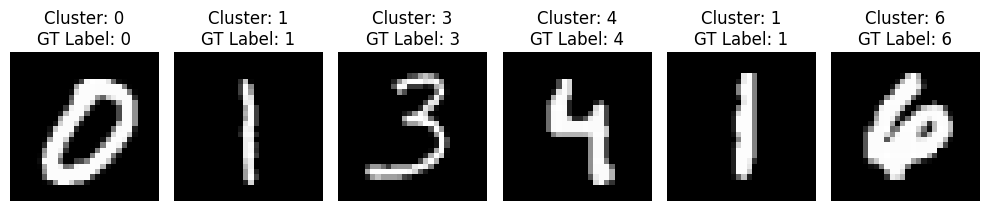

In [41]:

num_samples_to_visualize = 6
fig, axes = plt.subplots(1, num_samples_to_visualize, figsize=(10, 2))

for i in range(num_samples_to_visualize):
    # Choose a random index
    idx = np.random.randint(0, len(X))
    
    img = X[idx]
    y_true = Y[idx]
    
    predicted_cluster = y_pred_corr[idx]
    
    axes[i].imshow(img)
    axes[i].set_title(f"Cluster: {predicted_cluster}\nGT Label: {y_true}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

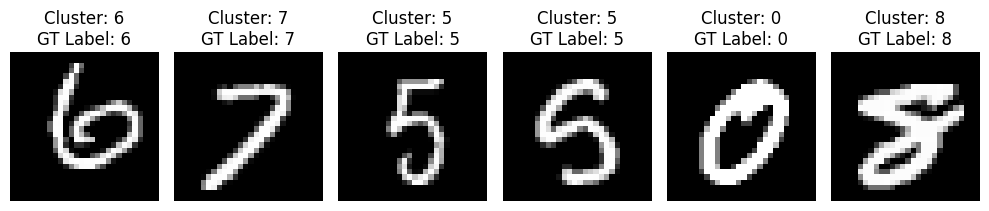

In [42]:
#x_test
num_samples_to_visualize = 6
fig, axes = plt.subplots(1, num_samples_to_visualize, figsize=(10, 2))

for i in range(num_samples_to_visualize):
    # Choose a random index
    idx = np.random.randint(0, len(x_test))
    
    img = x_test[idx]
    y_true = y_test[idx]
    
    predicted_cluster = y_pred_corr_test[idx]
    
    axes[i].imshow(img)
    axes[i].set_title(f"Cluster: {predicted_cluster}\nGT Label: {y_true}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()